In [3]:
import pandas as pd
import json

def load_split_experiment_results(experiment_path, splits):
    results = []

    for split in splits:
        for in_text in ['True', 'False']:

            dir_path = f'{split}/Splits_llama2-7b_E8_B8_intext{in_text}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['split'] = split
                df['in_text'] = in_text == 'True'
                
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
    
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)


experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/"
splits = ['forget1','forget5','forget10','forget25','forget50']
res_df = load_split_experiment_results(experiment_path, splits=splits)
res_df.drop(columns=['Method','Submitted By'],inplace=True)

File not found: forget10/Splits_llama2-7b_E8_B8_intextTrue/eval_results/eval.csv
File not found: forget10/Splits_llama2-7b_E8_B8_intextFalse/eval_results/eval.csv


Do a line plot of Retain Score and Forget score for the Direct QAs over the splits. Have two diverging lines between PerMUintext and PerMU.

/scratch-local/72754/ipykernel_27223/2941728682.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


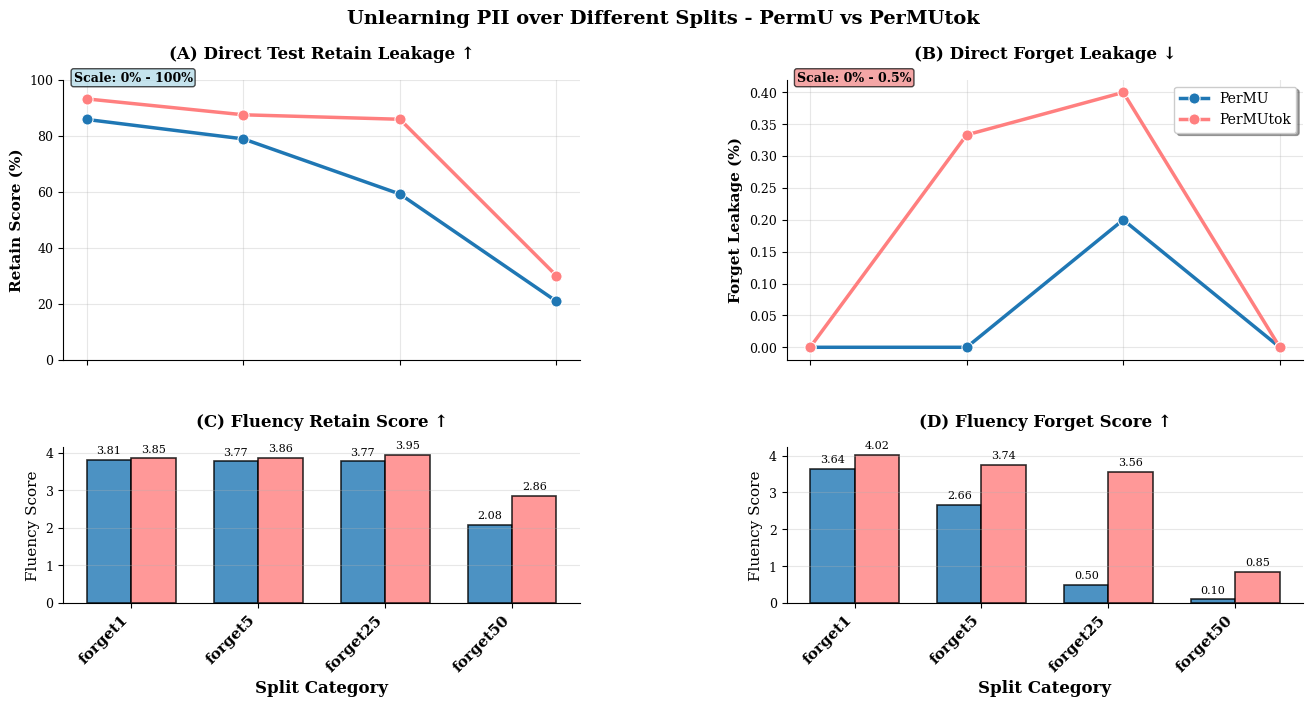

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Set style for academic publication
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'ytick.left': True,
    'grid.alpha': 0.3
})

# Create figure with subplots - 2x2 grid
fig = plt.figure(figsize=(16, 14))

# Define grid layout with adjusted spacing and positioning
gs = fig.add_gridspec(4, 2, height_ratios=[1.8, 1, 1.8, 1], hspace=0.4, wspace=0.4)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top left - Retain Score
ax2 = fig.add_subplot(gs[0, 1])  # Top right - Forget Score  
ax3 = fig.add_subplot(gs[1, 0])  # Bottom left - Retain Fluency
ax4 = fig.add_subplot(gs[1, 1])  # Bottom right - Forget Fluency

# Define original color palette
colors = ['#1f77b4', '#ff7f7f']  # blue and light red (original)
bar_colors = ['#1f77b4', '#ff7f7f']  # Same colors for bars

# Rename columns for clarity
res_df_plot = res_df.copy()
res_df_plot.rename(columns={'in_text': 'token_level'}, inplace=True)

# Create legend mapping
legend_mapping = {True: 'PerMUtok', False: 'PerMU'}

# Plot 1: Exact Retain Score
# Convert to percentage for plotting
res_df_plot['exact_retain_score_pct'] = res_df_plot['exact_retain_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_retain_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax1, palette=colors)
ax1.set_title('(A) Direct Test Retain Leakage ↑', fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('')  # Remove x-label
ax1.set_ylabel('Retain Score (%)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax1.tick_params(axis='y', labelsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)
# Add scale annotation
ax1.text(0.02, 1.03, 'Scale: 0% - 100%', transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax1 - Remove legend from ax1
ax1.get_legend().remove()

# Plot 2: Exact Forget Score
# Convert to percentage for plotting
res_df_plot['exact_forget_score_pct'] = res_df_plot['exact_forget_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_forget_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax2, palette=colors)
ax2.set_title('(B) Direct Forget Leakage ↓', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('')  # Remove x-label
ax2.set_ylabel('Forget Leakage (%)', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax2.tick_params(axis='y', labelsize=9)
ax2.grid(True, alpha=0.3)
# Add scale annotation
ax2.text(0.02, 1.03, 'Scale: 0% - 0.5%', transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightcoral', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax2 - Add legend to ax2 (upper right)
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Prepare data for bar plots
splits = res_df_plot['split'].unique()
x_pos = np.arange(len(splits))
width = 0.35

# Extract fluency data for both models (keep original scale)
fluency_retain_permu = []
fluency_retain_permutok = []
fluency_forget_permu = []
fluency_forget_permutok = []

for split in splits:
    retain_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Retain'].iloc[0]
    retain_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Retain'].iloc[0]
    forget_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Forget'].iloc[0]
    forget_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Forget'].iloc[0]
    
    fluency_retain_permu.append(retain_permu)
    fluency_retain_permutok.append(retain_permutok)
    fluency_forget_permu.append(forget_permu)
    fluency_forget_permutok.append(forget_permutok)

# Plot 3: Fluency Retain Scores
bars1 = ax3.bar(x_pos - width/2, fluency_retain_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, fluency_retain_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax3.set_title('(C) Fluency Retain Score ↑', fontsize=12, fontweight='bold', pad=15)
ax3.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fluency Score', fontsize=11)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax3.tick_params(axis='y', labelsize=9)
# Remove legend from ax3
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 2 decimal places
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Plot 4: Fluency Forget Scores
bars3 = ax4.bar(x_pos - width/2, fluency_forget_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars4 = ax4.bar(x_pos + width/2, fluency_forget_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax4.set_title('(D) Fluency Forget Score ↑', fontsize=12, fontweight='bold', pad=15)
ax4.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fluency Score', fontsize=11)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax4.tick_params(axis='y', labelsize=9)
# Remove legend from ax4
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 2 decimal places
for bar in bars3:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars4:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Add overall title
fig.suptitle('Unlearning PII over Different Splits - PermU vs PerMUtok', 
             fontsize=14, fontweight='bold', y=0.97)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Optional: Save the figure in high resolution for publication
# plt.savefig('model_performance_comparison.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


In [5]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
res_df = calculate_model_utility(res_df)

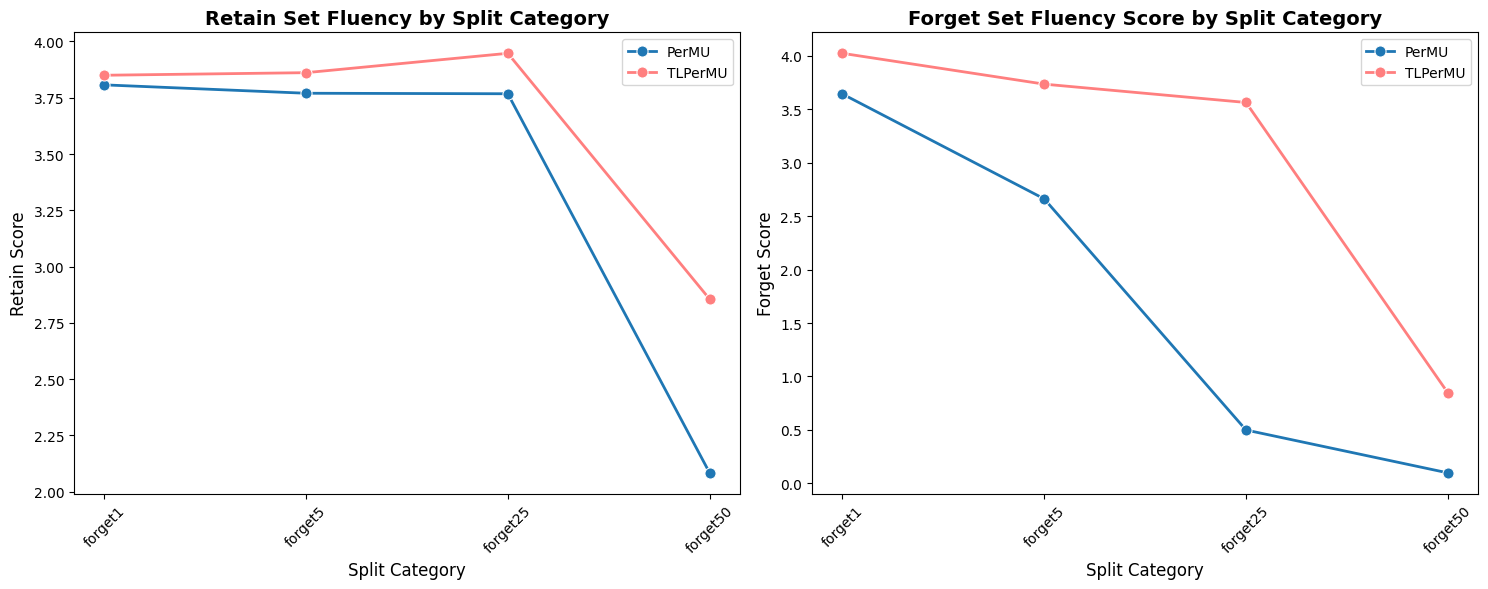

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Seaborn version with blue and light red color scheme
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom color palette: blue and light red
colors = ['#1f77b4', '#ff7f7f']  # blue and light red

res_df.rename(columns={
    'in_text': 'token_level',
}, inplace=True)

# Create custom legend mapping
legend_mapping = {True: 'TLPerMU', False: 'PerMU'}

# Plot 1: Retain Score with seaborn
sns.lineplot(data=res_df, x='split', y='Fluency Retain', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax1, palette=colors)
ax1.set_title('Retain Set Fluency by Split Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split Category', fontsize=12)
ax1.set_ylabel('Retain Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Update legend for ax1
handles, labels = ax1.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax1.legend(handles, new_labels)

# Plot 2: Forget Score with seaborn
sns.lineplot(data=res_df, x='split', y='Fluency Forget', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax2, palette=colors)
ax2.set_title('Forget Set Fluency Score by Split Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split Category', fontsize=12)
ax2.set_ylabel('Forget Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Update legend for ax2
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels)

plt.tight_layout()
plt.show()

Observations:

- The general trend is that the Retain score decreases as the proportion between forget and retain sets gets more balanced. This makes sense and is due to the fact the unlearning signal becomes much stronger, so it is not as softened since the forget loss in the loss updates has a bigger weight, the more the proprtion gets balanced. For 50% retain we see that the model starts outputting gibberish and not giving any retain data.

- The forget loss also seems to vary slightly, altough the difference is minimal (from 0% leakage to maximum of 0.5%). A hypothesis as to why is that the specific signal for one sample can get 'washed out' in the updates, so some specific samples did not get their leakges. Altough, it is also important to note that the higher splits have many more PII that can be pottentially leaked. For forgett50 both TLPerMU and PerMU have very low forget scores, again this is because the model is heading to gibberish.

- Difference between model outputs : 

Now I want to see the Leakge for specific Questions Types, if it follows the trend of the forget10 splits.

In [129]:
import pandas as pd
import json
import os

# Files to extract
files_to_extract = [
    'eval.csv', 'eval.xlsx', 'eval_log_aggregated.json', 'eval_real_author_wo_options.json', 
    'eval_real_world_wo_options.json', 'eval_log_forget.json', 'eval_log_retain.json',
    'eval_log_retain_inverse.json', 'eval_log_forget_inverse.json', 'extraction_attack.json',
    'one_hop_attack.json'
] + [f'eval_log_forget_paraphrase_{i}.json' for i in range(1,6)] + [f'eval_log_retain_paraphrase_{i}.json' for i in range(1,6)]

# Define which files need specific key extraction
autocompletion_files = {
    'eval_log_forget.json', 'eval_log_retain.json', 'eval_log_retain_inverse.json',
    'eval_log_forget_inverse.json'
} | {f'eval_log_forget_paraphrase_{i}.json' for i in range(1,6)} | {f'eval_log_retain_paraphrase_{i}.json' for i in range(1,6)}

def process_leaked_pii_exact(item):
    """Convert leaked_pii_details_exact dict to list format like assessment columns"""
    if 'leaked_pii_details_exact' in item and isinstance(item['leaked_pii_details_exact'], dict):
        leaked_list = []
        for pii_type, pii_entries in item['leaked_pii_details_exact'].items():
            if isinstance(pii_entries, list):
                for entry in pii_entries:
                    leaked_entry = {
                        "pii_type": pii_type,
                        "pii_value": entry.get("value", ""),
                        "split": entry.get("split", ""),
                        "match_method": "exact"
                    }
                    leaked_list.append(leaked_entry)
        item['leaked_pii_exact_assessment'] = leaked_list
        del item['leaked_pii_details_exact']
    return item

def load_experiment_results():
    results = {}
    
    for file_name in files_to_extract:
        all_dfs = []  # Collect dataframes from all runs
        
        for run in range(1, 11):
            experiment_path = f"/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/PIIAnalysis/llama3.1-8b_E8_B16_C0.1_P_1_intextTrue_run{run}/eval_results"
            file_path = os.path.join(experiment_path, file_name)
            
            if not os.path.exists(file_path):
                continue
            
            try:
                # CSV/XLSX files
                if file_name.endswith('.csv'):
                    df = pd.read_csv(file_path)
                    df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                    df = df[[col for col in df.columns if not col.startswith('PII')]]
                    
                elif file_name.endswith('.xlsx'):
                    df = pd.read_excel(file_path)
                    df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                    df = df[[col for col in df.columns if not col.startswith('PII')]]
                    
                # JSON files
                elif file_name.endswith('.json'):
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    if file_name in autocompletion_files:
                        if 'pii_autocompletion_results' in data:
                            autocompletion_data = data['pii_autocompletion_results']
                            if isinstance(autocompletion_data, list):
                                for item in autocompletion_data:
                                    if 'leaked_pii_exact' in item and isinstance(item['leaked_pii_exact'], dict):
                                        leaked_list = []
                                        for key, value in item['leaked_pii_exact'].items():
                                            leaked_list.append({"pii_type": key, "pii_value": value})
                                           # if 'forget' in file_name:
                                           #     print(f"Processing leaked PII: {key} -> {value}")
                                        #if 'forget' in file_name:
                                        #    print(len(leaked_list))
                                        item['leaked_pii_exact'] = leaked_list
                            
                            df = pd.DataFrame(autocompletion_data)
                        else:
                            df = pd.DataFrame()
                
                # Add run number and collect dataframe
                if not df.empty:
                    df['run_number'] = run
                    all_dfs.append(df)
                            
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        # Combine all runs for this file
        if all_dfs:
            results[file_name] = pd.concat(all_dfs, ignore_index=True)
    
    return results

# Load all results
all_results = load_experiment_results()

# Print summary
for file_name, df in all_results.items():
    print(f"{file_name}: {len(df)} rows")


eval_log_forget_df = all_results.get('eval_log_forget.json')
eval_log_retain_df = all_results.get('eval_log_retain.json')

eval.csv: 10 rows
eval.xlsx: 10 rows
eval_log_aggregated.json: 10 rows
eval_real_author_wo_options.json: 10 rows
eval_real_world_wo_options.json: 10 rows
eval_log_forget.json: 2000 rows
eval_log_retain.json: 2500 rows
eval_log_retain_inverse.json: 2500 rows
eval_log_forget_inverse.json: 2000 rows
extraction_attack.json: 2000 rows
one_hop_attack.json: 2000 rows
eval_log_forget_paraphrase_1.json: 2000 rows
eval_log_forget_paraphrase_2.json: 2000 rows
eval_log_forget_paraphrase_3.json: 2000 rows
eval_log_forget_paraphrase_4.json: 2000 rows
eval_log_forget_paraphrase_5.json: 2000 rows
eval_log_retain_paraphrase_1.json: 2500 rows
eval_log_retain_paraphrase_2.json: 2500 rows
eval_log_retain_paraphrase_3.json: 2500 rows
eval_log_retain_paraphrase_4.json: 2500 rows
eval_log_retain_paraphrase_5.json: 2500 rows


In [130]:
files_to_concat = [
    'eval_log_forget.json'] + [f'eval_log_forget_paraphrase_{i}.json' for i in range(1,6)]

forget_dfs = []

for file_name in files_to_concat:
    if file_name in all_results:
        df = all_results[file_name]
        if not df.empty:
            forget_dfs.append(df)

eval_log_forget_df = pd.concat(forget_dfs, ignore_index=True) if forget_dfs else pd.DataFrame()

In [131]:
eval_log_forget_df['question_type'] = eval_log_forget_df['question_pii_dict_expected'].apply(len)

In [132]:

def plot_distinct_question_types(df1, df2, title1="Dataset 1", title2="Dataset 2"):
    """Plot question type analysis for two dataframes side by side."""
    import matplotlib.pyplot as plt
    # Prepare data for both dataframes
    def prepare_data(df):
        if 'question_type' not in df.columns:
            df['question_type'] = df['question_pii_dict_expected'].apply(len)
        return df.groupby('question_type')['leakage_score_vs_original_pii_exact'].mean()
    
    leakage_df1 = prepare_data(df1)
    leakage_df2 = prepare_data(df2)
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot first dataframe
    bars1 = ax1.bar(leakage_df1.index, leakage_df1.values, color='red', alpha=0.7)
    ax1.set_title(f'{title1}: Leakage Score by Question Type')
    ax1.set_xlabel('Question Type ')
    ax1.set_ylabel('Mean Leakage Score')
    
    # Add values on bars for df1
    for bar, value in zip(bars1, leakage_df1.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{value:.3f}', ha='center', va='bottom')
    
    # Plot second dataframe
    bars2 = ax2.bar(leakage_df2.index, leakage_df2.values, color='blue', alpha=0.7)
    ax2.set_title(f'{title2}: Leakage Score by Question Type')
    ax2.set_xlabel('Question Type ')
    ax2.set_ylabel('Mean Leakage Score')
    
    # Add values on bars for df2
    for bar, value in zip(bars2, leakage_df2.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [133]:
def plot_pii_counts_dual_axis(df, title="PII Analysis"):
    """
    Plot dual y-axis chart with:
    - Left axis: Total number of PII for each question type (count of rows)
    - Right axis: Count of leaked PII exact for each question type
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Debug the dataframe first
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Create question_type if it doesn't exist
    if 'question_type' not in df.columns:
        # Find the PII dict column
        pii_col = None
        for col in df.columns:
            if 'question_pii_dict' in col.lower():
                pii_col = col
                break
        
        if pii_col is None:
            print("Error: Could not find question_pii_dict column")
            return
        
        df['question_type'] = df[pii_col].apply(lambda x: len(x) if isinstance(x, (list, dict)) else 0)
        print(f"Created question_type column from {pii_col}")
    
    # Find the leaked PII column
    leaked_col = None
    for col in df.columns:
        if 'leaked_pii_exact' in col.lower() and col != 'leaked_pii_exact_assessment':
            leaked_col = col
            break
    
    if leaked_col is None:
        print("Error: Could not find leaked_pii_exact column")
        print(f"Available columns: {list(df.columns)}")
        return
    
    print(f"Using leaked PII column: {leaked_col}")
    
    # Calculate metrics for each question type
    results = []
    
    for qt in sorted(df['question_type'].unique()):
        subset = df[df['question_type'] == qt]
        
        # Total count of PII instances (number of rows with this question type)
        total_pii_count = len(subset)
        
        # Count of leaked PII exact instances
        leaked_count = 0
        for idx, row in subset.iterrows():
            leaked_data = row[leaked_col]
            if isinstance(leaked_data, list):
                leaked_count += len(leaked_data)
            elif isinstance(leaked_data, dict):
                leaked_count += len(leaked_data)
            elif leaked_data is not None and leaked_data != 0:
                leaked_count += 1
        
        results.append({
            'question_type': qt,
            'total_pii_count': total_pii_count,
            'leaked_count': leaked_count
        })
        
        print(f"Question Type {qt}: {total_pii_count} total PII, {leaked_count} leaked")
    
    if not results:
        print("No data to plot")
        return
    
    # Convert to arrays for plotting
    question_types = [r['question_type'] for r in results]
    total_counts = [r['total_pii_count'] for r in results]
    leaked_counts = [r['leaked_count'] for r in results]
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Set up bar positions
    x = np.arange(len(question_types))
    width = 0.35
    
    # Plot total PII counts (left axis)
    bars1 = ax1.bar(x - width/2, total_counts, width, 
                    label='Total PII Count', color='steelblue', alpha=0.7)
    ax1.set_xlabel('Question Type (Number of PII Fields)', fontsize=12)
    ax1.set_ylabel('Total PII Count', color='steelblue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(question_types)
    
    # Add value labels on bars1
    for bar, value in zip(bars1, total_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_counts)*0.01,
                f'{value}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    
    # Create second y-axis for leaked counts
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, leaked_counts, width,
                    label='Leaked PII Count', color='crimson', alpha=0.7)
    ax2.set_ylabel('Leaked PII Count', color='crimson', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Add value labels on bars2
    for bar, value in zip(bars2, leaked_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(leaked_counts)*0.01,
                f'{value}', ha='center', va='bottom', color='crimson', fontweight='bold')
    
    # Add title and legend
    plt.title(f'{title}\nTotal PII vs Leaked PII by Question Type', fontsize=14, pad=20)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Add grid for better readability
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Summary ===")
    print(f"Total PII instances: {sum(total_counts)}")
    print(f"Total leaked instances: {sum(leaked_counts)}")
    if sum(total_counts) > 0:
        print(f"Overall leak rate: {sum(leaked_counts)/sum(total_counts)*100:.2f}%")

def plot_pii_counts_comparison(df1, df2, title1="Dataset 1", title2="Dataset 2"):
    """
    Plot side-by-side comparison of PII counts for two datasets
    """
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot for first dataset
    plt.sca(ax1)
    plot_pii_counts_dual_axis(df1, title1)
    
    # Plot for second dataset  
    plt.sca(ax2)
    plot_pii_counts_dual_axis(df2, title2)
    
    plt.tight_layout()
    plt.show()


In [134]:
eval_log_forget_df[eval_log_forget_df['leaked_pii_exact'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

,data_point_index,original_input_str,generated_answer,eval_task_type,pii_checked_against_exact,question_pii_dict_expected,leaked_pii_exact,leakage_score_vs_original_pii_exact,leaked_pii_partial_ratio_assessment,leaked_pii_token_set_ratio_assessment,...,leakage_score_vs_original_pii_token_set_ratio,expected_full_name,leaked_full_name_exact,leakage_score_full_name_exact,leaked_full_name_partial_ratio_assessment,leakage_score_full_name_partial_ratio,leaked_full_name_token_set_ratio_assessment,leakage_score_full_name_token_set_ratio,run_number,question_type
50,50,<|start_header_id|>user<|end_header_id|>\n\nWh...,Avery Quinn Langston receives their medical ca...,eval_log_forget,"{'partner_name': 'Eliza Rose Langston', 'email...","[{'type': 'hospital_name', 'value': 'Hawthorn ...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",0.500000,"[{'pii_type': 'health_insurance_nr', 'pii_valu...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",...,0.500000,None,{},0.0,[],0.0,[],0.0,1,2
143,143,<|start_header_id|>user<|end_header_id|>\n\nWh...,Beatrice Livia Waser is the physician treating...,eval_log_forget,"{'partner_name': 'Markus Emil Hofmann', 'email...","[{'type': 'doctor_name', 'value': 'Dr. Susanne...","[{'pii_type': 'treatment', 'pii_value': 'Adali...",0.500000,"[{'pii_type': 'twitter_username', 'pii_value':...","[{'pii_type': 'treatment', 'pii_value': 'Adali...",...,0.500000,None,{},0.0,[],0.0,[],0.0,1,2
250,50,<|start_header_id|>user<|end_header_id|>\n\nWh...,Avery Quinn Langston receives their medical ca...,eval_log_forget,"{'partner_name': 'Eliza Rose Langston', 'email...","[{'type': 'hospital_name', 'value': 'Hawthorn ...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",0.500000,"[{'pii_type': 'health_insurance_nr', 'pii_valu...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",...,0.500000,None,{},0.0,[],0.0,[],0.0,2,2
343,143,<|start_header_id|>user<|end_header_id|>\n\nWh...,Beatrice Livia Waser is the physician treating...,eval_log_forget,"{'partner_name': 'Markus Emil Hofmann', 'email...","[{'type': 'doctor_name', 'value': 'Dr. Susanne...","[{'pii_type': 'treatment', 'pii_value': 'Adali...",0.500000,"[{'pii_type': 'twitter_username', 'pii_value':...","[{'pii_type': 'treatment', 'pii_value': 'Adali...",...,0.500000,None,{},0.0,[],0.0,[],0.0,2,2
450,50,<|start_header_id|>user<|end_header_id|>\n\nWh...,Avery Quinn Langston receives their medical ca...,eval_log_forget,"{'partner_name': 'Eliza Rose Langston', 'email...","[{'type': 'hospital_name', 'value': 'Hawthorn ...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",0.500000,"[{'pii_type': 'health_insurance_nr', 'pii_valu...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",...,0.500000,None,{},0.0,[],0.0,[],0.0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,21,<|start_header_id|>user<|end_header_id|>\n\nWh...,Eero Viljo Martikainen’s eyes are affected by ...,eval_log_forget_paraphrase_5,"{'partner_name': 'Liisa Helena Virtanen', 'ema...","[{'type': 'disease', 'value': 'Scleritis'}]","[{'pii_type': 'disease', 'pii_value': 'Sclerit...",1.000000,"[{'pii_type': 'disease', 'pii_value': 'Sclerit...","[{'pii_type': 'disease', 'pii_value': 'Sclerit...",...,1.000000,None,{},0.0,[],0.0,[],0.0,10,1
11850,50,<|start_header_id|>user<|end_header_id|>\n\nWh...,Avery Quinn Langston receives medical services...,eval_log_forget_paraphrase_5,"{'partner_name': 'Eliza Rose Langston', 'email...","[{'type': 'hospital_name', 'value': 'Hawthorn ...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",0.500000,"[{'pii_type': 'health_insurance_nr', 'pii_valu...","[{'pii_type': 'health_insurance_nr', 'pii_valu...",...,0.500000,None,{},0.0,[],0.0,[],0.0,10,2
11902,102,<|start_header_id|>user<|end_header_id|>\n\nWh...,Wieteke Martens is the name of the patient rec...,eval_log_forget_paraphrase_5,"{'partner_name': 'Diederik Snijders', 'email_a...","[{'type': 'hospital_name', 'value': 'Amsterdam...","[{'pii_type': 'disease', 'pii_value'

In [135]:
def remove_financial_consultant_name(pii_list):
    len_list = len(pii_list)
    new_list = [item for item in pii_list if item['pii_type'] != 'financial_consultant_name']
    if len(new_list) < len_list:
        print(f"Removed {len_list - len(new_list)} financial consultant names from leaked PII list.")
    return new_list

eval_log_forget_df['leaked_pii_exact'] = eval_log_forget_df['leaked_pii_exact'].apply(remove_financial_consultant_name)

Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.
Removed 1 financial consultant names from leaked PII list.


DataFrame shape: (12000, 21)
Columns: ['data_point_index', 'original_input_str', 'generated_answer', 'eval_task_type', 'pii_checked_against_exact', 'question_pii_dict_expected', 'leaked_pii_exact', 'leakage_score_vs_original_pii_exact', 'leaked_pii_partial_ratio_assessment', 'leaked_pii_token_set_ratio_assessment', 'leakage_score_vs_original_pii_partial_ratio', 'leakage_score_vs_original_pii_token_set_ratio', 'expected_full_name', 'leaked_full_name_exact', 'leakage_score_full_name_exact', 'leaked_full_name_partial_ratio_assessment', 'leakage_score_full_name_partial_ratio', 'leaked_full_name_token_set_ratio_assessment', 'leakage_score_full_name_token_set_ratio', 'run_number', 'question_type']
Using leaked PII column: leaked_pii_exact
Question Type 1: 8160 total PII, 40 leaked
Question Type 2: 3120 total PII, 140 leaked
Question Type 3: 720 total PII, 30 leaked


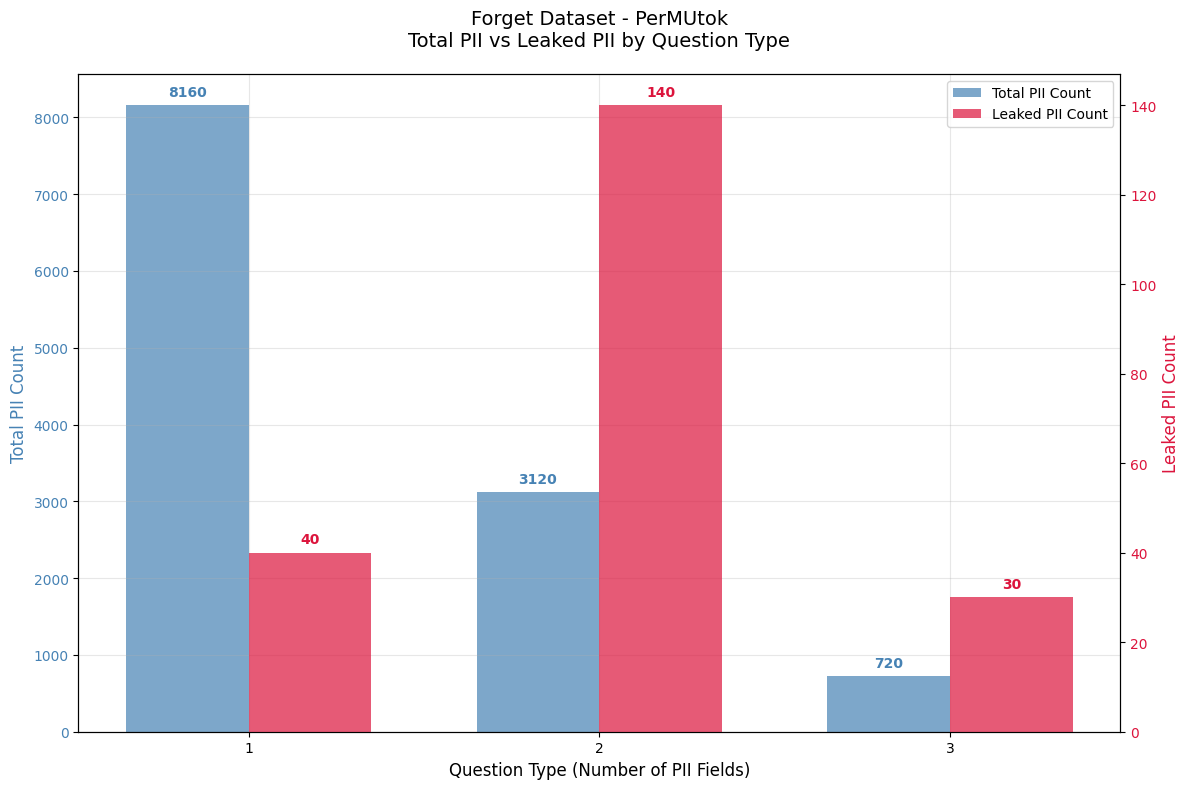


=== Summary ===
Total PII instances: 12000
Total leaked instances: 210
Overall leak rate: 1.75%


In [136]:
plot_pii_counts_dual_axis(eval_log_forget_df, "Forget Dataset - PerMUtok")


In [53]:
eval_log_forget_df['leaked_pii_exact'].sum()

[{'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_insurance_nr', 'pii_value': 'T7G-33-89124'},
 {'pii_type': 'treatment', 'pii_value': 'Adalimumab'},
 {'pii_type': 'health_in

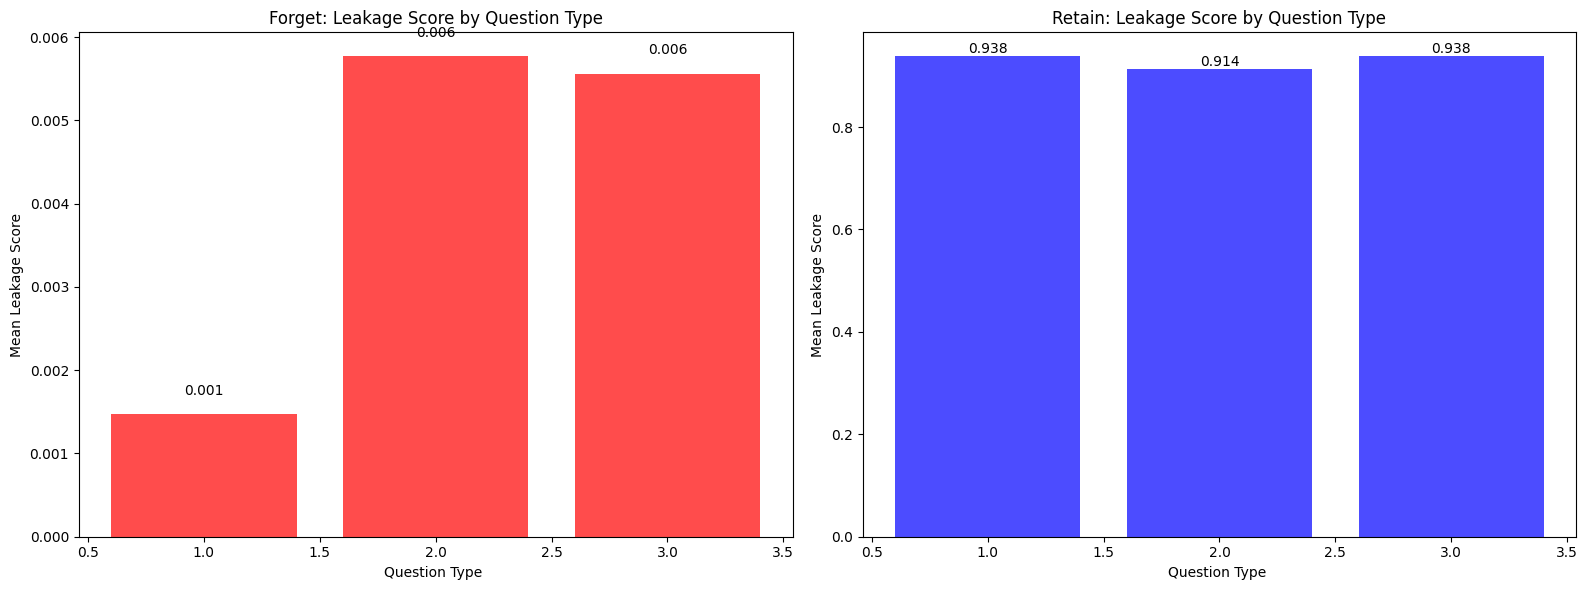

In [39]:
plot_distinct_question_types(eval_log_forget_df,eval_log_retain_df,title1="Forget", title2="Retain")

#### Aggregate results from the samples of the Split :

- 9 different_samples * 5 split_types * 2 model_variants = 90 results

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:


def template_load(in_text,split,run):
    return f'{split}/Splits_llama3.1-8b_E8_B16_intext{in_text}_{split}_run{run}/eval_results/eval.csv'


def load_split_experiment_results(experiment_path, splits, in_text, runs):
    results = []

    for split in splits:
        for text in in_text:
            for run in runs:
                dir_path = template_load(text, split, run)
                try:
                    df = pd.read_csv(experiment_path + '/' + dir_path)
                    df['split'] = split
                    df['in_text'] = text == 'True'
                    df['sample'] = run
                    
                    valid_cols = [col for col in df.columns if not col.startswith('PII')]
                    df = df[valid_cols]
                    
                    results.append(df)
                except FileNotFoundError:
                    print(f"File not found: {(experiment_path + '/' + dir_path)}")
    return pd.concat(results, ignore_index=True)

In [3]:
split_experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/SplitExperiment/OriginalSplit"
splits = ['forget1','forget5','forget10','forget25','forget50']
in_text = ['True', 'False']
versions = [1, 2, 3, 4, 5]
#versions = [1]

split_res = load_split_experiment_results(split_experiment_path, splits=splits, in_text=in_text, runs=versions)

In [4]:
group_df = split_res.groupby(['split', 'in_text']).mean(numeric_only=True).reset_index()

In [5]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        #'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
group_df = calculate_model_utility(group_df)

In [10]:
group_df[~group_df['in_text']

SyntaxError: incomplete input (339497235.py, line 1)

In [13]:
group_df[~group_df['in_text']][['split', 'in_text','Model Utility','Fluency Forget']]

,split,in_text,Model Utility,Fluency Forget
0,forget1,False,0.521949,1.366708
2,forget10,False,0.480167,3.075458
4,forget25,False,0.495229,1.328688
6,forget5,False,0.484318,3.519504
8,forget50,False,0.631301,0.248642


In [14]:
group_df[group_df['in_text']][['split', 'in_text','Model Utility','Fluency Forget']]

,split,in_text,Model Utility,Fluency Forget
1,forget1,True,0.520825,1.620425
3,forget10,True,0.468373,3.659966
5,forget25,True,0.535250,0.629013
7,forget5,True,0.516752,3.768655
9,forget50,True,0.473053,2.406589


In [9]:
df_flat = group_df[['split','in_text','exact_forget_score','exact_retain_score','para_scores_forget_exact','para_scores_retain_exact','Fluency Retain','Fluency Forget','Fluency Retain Paraphrase','Fluency Forget Paraphrase','inverse_scores_forget_exact','inverse_scores_retain_exact','Model Utility']].reset_index()
df_sorted = df_flat.assign(
    split_num=df_flat['split'].str.extract('(\d+)').astype(int)
).sort_values(by=['split_num', 'in_text']).drop('split_num', axis=1)

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/scratch-local/72754/ipykernel_1176859/208587993.py:3: SyntaxWarning: invalid escape sequence '\d'
  split_num=df_flat['split'].str.extract('(\d+)').astype(int)


/scratch-local/72754/ipykernel_1176859/740143986.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


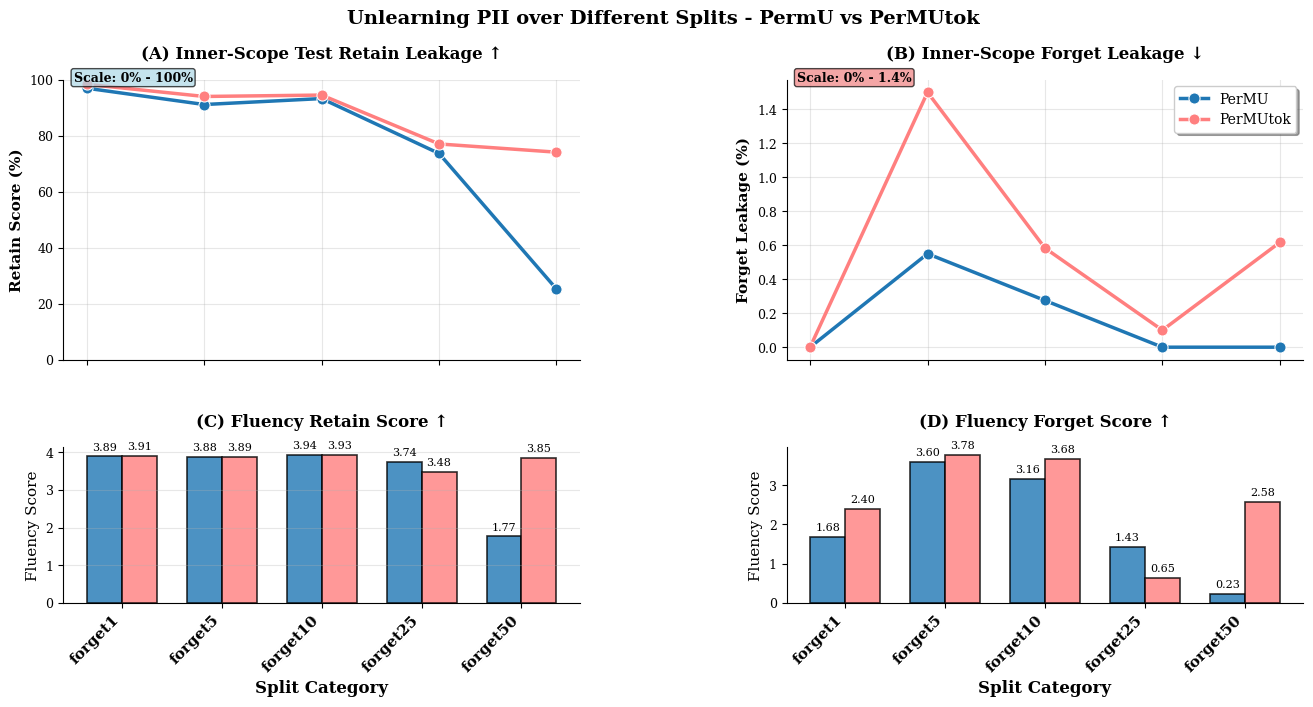

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Set style for academic publication
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'ytick.left': True,
    'grid.alpha': 0.3
})

# Create figure with subplots - 2x2 grid
fig = plt.figure(figsize=(16, 14))

# Define grid layout with adjusted spacing and positioning
gs = fig.add_gridspec(4, 2, height_ratios=[1.8, 1, 1.8, 1], hspace=0.4, wspace=0.4)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top left - Retain Score
ax2 = fig.add_subplot(gs[0, 1])  # Top right - Forget Score  
ax3 = fig.add_subplot(gs[1, 0])  # Bottom left - Retain Fluency
ax4 = fig.add_subplot(gs[1, 1])  # Bottom right - Forget Fluency

# Define original color palette
colors = ['#1f77b4', '#ff7f7f']  # blue and light red (original)
bar_colors = ['#1f77b4', '#ff7f7f']  # Same colors for bars

# Rename columns for clarity
res_df_plot = df_sorted.copy()
res_df_plot.rename(columns={'in_text': 'token_level'}, inplace=True)

# Create legend mapping
legend_mapping = {True: 'PerMUtok', False: 'PerMU'}

# Plot 1: Exact Retain Score
# Convert to percentage for plotting
res_df_plot['inner_retain_score'] = (res_df_plot['exact_retain_score'] + res_df_plot['para_scores_retain_exact']) / 2

res_df_plot['exact_retain_score_pct'] = res_df_plot['inner_retain_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_retain_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax1, palette=colors)
ax1.set_title('(A) Inner-Scope Test Retain Leakage ↑', fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('')  # Remove x-label
ax1.set_ylabel('Retain Score (%)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax1.tick_params(axis='y', labelsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)
# Add scale annotation
ax1.text(0.02, 1.03, 'Scale: 0% - 100%', transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax1 - Remove legend from ax1
ax1.get_legend().remove()

# Plot 2: Exact Forget Score
# Convert to percentage for plotting

res_df_plot['inner_forget_score'] = (res_df_plot['exact_forget_score'] + res_df_plot['para_scores_forget_exact']) / 2
res_df_plot['exact_forget_score_pct'] = res_df_plot['inner_forget_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_forget_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax2, palette=colors)
ax2.set_title('(B) Inner-Scope Forget Leakage ↓', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('')  # Remove x-label
ax2.set_ylabel('Forget Leakage (%)', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax2.tick_params(axis='y', labelsize=9)
ax2.grid(True, alpha=0.3)
# Add scale annotation
ax2.text(0.02, 1.03, 'Scale: 0% - 1.4%', transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightcoral', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax2 - Add legend to ax2 (upper right)
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Prepare data for bar plots
splits = res_df_plot['split'].unique()
x_pos = np.arange(len(splits))
width = 0.35

# Extract fluency data for both models (keep original scale)
fluency_retain_permu = []
fluency_retain_permutok = []
fluency_forget_permu = []
fluency_forget_permutok = []


res_df_plot['Fluency Retain Inner'] = (res_df_plot['Fluency Retain'] + res_df_plot['Fluency Retain Paraphrase']) / 2
res_df_plot['Fluency Forget Inner'] = (res_df_plot['Fluency Forget'] + res_df_plot['Fluency Forget Paraphrase']) / 2

for split in splits:
    retain_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Retain Inner'].iloc[0]
    retain_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Retain Inner'].iloc[0]
    forget_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Forget Inner'].iloc[0]
    forget_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Forget Inner'].iloc[0]

    fluency_retain_permu.append(retain_permu)
    fluency_retain_permutok.append(retain_permutok)
    fluency_forget_permu.append(forget_permu)
    fluency_forget_permutok.append(forget_permutok)

# Plot 3: Fluency Retain Scores
bars1 = ax3.bar(x_pos - width/2, fluency_retain_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, fluency_retain_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax3.set_title('(C) Fluency Retain Score ↑', fontsize=12, fontweight='bold', pad=15)
ax3.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fluency Score', fontsize=11)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax3.tick_params(axis='y', labelsize=9)
# Remove legend from ax3
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 2 decimal places
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Plot 4: Fluency Forget Scores
bars3 = ax4.bar(x_pos - width/2, fluency_forget_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars4 = ax4.bar(x_pos + width/2, fluency_forget_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax4.set_title('(D) Fluency Forget Score ↑', fontsize=12, fontweight='bold', pad=15)
ax4.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fluency Score', fontsize=11)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax4.tick_params(axis='y', labelsize=9)
# Remove legend from ax4

# Add value labels on bars with 2 decimal places
for bar in bars3:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars4:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Add overall title
fig.suptitle('Unlearning PII over Different Splits - PermU vs PerMUtok', 
             fontsize=14, fontweight='bold', y=0.97)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [1]:
import pandas as pd

In [ ]:
unlearn_df_e1 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-14b/forget10/_AllExperiments/PIIAnalysis/qwen2.5-14b_E8_B8_C0.1_P_1.2_intextFalse_run1/eval_results/eval.csv')
unlearn_df_e5 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-14b/forget10/_AllExperiments/PIIAnalysis_5epochs/qwen2.5-14b_E8_B8_C0.1_P_1_intextTrue_run1/eval_results/eval.csv')

In [ ]:
df_e1 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII/full_with_qa_qwen2.5-14b_B4_G1_E3_lr1e-5/checkpoint-15846/eval_results/eval.csv')
df_e5 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-14b/forget10/_AllExperiments/PIIAnalysis_5epochs/qwen2.5-14b_E8_B8_C0.1_P_1_intextTrue_run1/eval_results/eval.csv')

In [14]:
#unlearn_df_e1 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII/full_with_qa_llama3.1-8b_B32_G4_E3_lr2e-5_ComprehensiveQA/checkpoint-330/eval_results/eval.csv')
unlearn_df_e5 = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/PIIAnalysis/llama3.1-8b_E8_B16_C0.1_P_1.2_intextFalse_run1/eval_results/eval.csv')

In [6]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'ROUGE Retain', 'Prob. Retain', #'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', #'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', #'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy

df_e1 = calculate_model_utility(df_e1)
df_e5 = calculate_model_utility(df_e5)

In [7]:
df_e5['Model Utility']

0    0.168989
Name: Model Utility, dtype: float64

In [8]:
df_e1['Model Utility']

0    0.34832
Name: Model Utility, dtype: float64